In [ ]:
%reload_ext autoreload
%autoreload 2

In [ ]:
from fastai import *
from fastai.vision import *

## LSun data

In [ ]:
PATH = Path('../data/lsun')
IMG_PATH = PATH/'bedroom'

In [ ]:
def create_csv_file(sample=False):
    files = PATH.glob('bedroom/**/*.jpg')
    with (PATH/'files.csv').open('w') as fo:
        for f in files: 
            if not sample or random.random() < 0.1: fo.write(f'{f},0\n')

In [ ]:
#create_csv_file(sample=True)

In [ ]:
df = pd.read_csv(PATH/'files.csv', header=None)
fns, ys = np.array(df[0]), np.array(df[1])
train_ds = ImageDataset(fns, ys)

In [ ]:
size = 64
train_tds = DatasetTfm(train_ds, tfms = [crop_pad(size=size, row_pct=(0,1), col_pct=(0,1))], size=size)

In [ ]:
data = DataBunch.create(train_tds, valid_ds=None, bs=128)
data.valid_dl = None

## Models

In [ ]:
def conv_bn_lr(ni:int, nf:int, ks:int=3, stride:int=1, slope=0.1, bn:bool=True)->nn.Sequential:
    "Create Conv2d->BatchNorm2d->LeakyReLu layer with `slope`: `ni` input, `nf` out filters, `ks` kernel, `stride`:stride."
    layers = [conv2d(ni, nf, ks, stride)]
    if bn: layers.append(nn.BatchNorm2d(nf))
    layers.append(nn.LeakyReLU(negative_slope=slope, inplace=True))
    return nn.Sequential(*layers)

In [ ]:
def convT_bn_relu(ni:int, nf:int, ks:int=2, stride:int=2, padding:int=0, slope=0.1, bn:bool=True)->nn.Sequential:
    "Create Conv2dT->BatchNorm2d->LeakyReLu layer with `slope`: `ni` input, `nf` out filters, `ks` kernel, `stride`:stride."
    layers = [conv2d_trans(ni, nf, ks, stride, padding)]
    if bn: layers.append(nn.BatchNorm2d(nf))
    layers.append(nn.LeakyReLU(negative_slope=slope, inplace=True))
    return nn.Sequential(*layers)

In [ ]:
def AvgFlatten():
    return Lambda(lambda x: x.mean().view(1)[0])

In [ ]:
def discriminator(in_size, n_channels, n_features, n_extra_layers=0):
    layers = [conv_bn_lr(n_channels, n_features, 4, 2, bn=False)]
    cur_size, cur_ftrs = in_size//2, n_features
    layers.append(nn.Sequential(*[conv_bn_lr(cur_ftrs, cur_ftrs, 3, 1) for _ in range(n_extra_layers)]))
    while cur_size > 4:
        layers.append(conv_bn_lr(cur_ftrs, cur_ftrs*2, 4, 2))
        cur_ftrs *= 2 ; cur_size //= 2
    layers += [conv2d(cur_ftrs, 1, 4, padding=0), AvgFlatten()]
    return nn.Sequential(*layers)

In [ ]:
def generator(in_size, noise_sz, n_channels, n_features, n_extra_layers=0):
    cur_size, cur_ftrs = 4, n_features//2
    while cur_size < in_size:  cur_size *= 2; cur_ftrs *= 2
    layers = [convT_bn_relu(noise_sz, cur_ftrs, 4, 1)]
    cur_size = 4
    while cur_size < in_size // 2:
        layers.append(convT_bn_relu(cur_ftrs, cur_ftrs//2, 4, 2, 1))
        cur_ftrs //= 2; cur_size *= 2
    layers += [convT_bn_relu(cur_ftrs, cur_ftrs, 3, 1, 1) for _ in range(n_extra_layers)]
    layers.append(conv2d_trans(cur_ftrs, n_channels, 4, 2, 1))
    return nn.Sequential(*layers)

In [ ]:
generator(64, 100, 3, 64, 1)

Sequential(
  (0): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1))
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.1, inplace)
  )
  (1): Sequential(
    (0): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.1, inplace)
  )
  (2): Sequential(
    (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.1, inplace)
  )
  (3): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.1, inplace)
  )
  (4): Sequential(

In [ ]:
discriminator(64, 3, 64, 1)

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(2, 2), bias=False)
    (1): LeakyReLU(negative_slope=0.1, inplace)
  )
  (1): Sequential(
    (0): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.1, inplace)
    )
  )
  (2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(2, 2), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.1, inplace)
  )
  (3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(2, 2), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.1, inplace)
  )
  (4): Sequential(
    (0): Conv2d(256, 512, kernel_

In [ ]:
class WGAN(nn.Module):
    
    def __init__(self, in_size, noise_sz, n_channels, n_features, n_extra_layers=0):
        super().__init__()
        self.discriminator = discriminator(in_size, n_channels, n_features, n_extra_layers)
        self.generator = generator(in_size, noise_sz, n_channels, n_features, n_extra_layers)
    
    def forward(self, x, gen=False):
        return self.generator(x) if gen else self.discriminator(x)

In [ ]:
def standard_disc_iter(gen_iter):
    return 100 if (gen_iter < 25 or gen_iter%500 == 0) else 5

In [ ]:
noise_sz = 100
def create_noise(x, b): return x.new(b, noise_sz, 1, 1).normal_(0, 1)

In [ ]:
@dataclass
class GANTrainer(LearnerCallback):
    n_disc_iter:Callable = standard_disc_iter
    clip:float = -0.01
    bs:int = 64
    
    def _set_trainable(self, gen=False):
        requires_grad(self.learn.model.generator, gen)
        requires_grad(self.learn.model.discriminator, not gen)
        if gen:
            self.opt_gen.lr, self.opt_gen.mom = self.learn.opt.lr, self.learn.opt.mom
            self.opt_gen.wd, self.opt_gen.beta = self.learn.opt.wd, self.learn.opt.beta
    
    def on_train_begin(self, **kwargs):
        opt_fn = self.learn.opt_fn
        lr, wd, true_wd, bn_wd = self.learn.opt.lr, self.learn.opt.wd, self.learn.opt.true_wd, self.learn.opt.bn_wd
        self.opt_gen = OptimWrapper.create(opt_fn, lr, 
                                      [nn.Sequential(*flatten_model(self.learn.model.generator))], 
                                      wd=wd, true_wd=true_wd, bn_wd=bn_wd)
        self.opt_disc = OptimWrapper.create(opt_fn, lr, 
                                      [nn.Sequential(*flatten_model(self.learn.model.discriminator))],
                                      wd=wd, true_wd=true_wd, bn_wd=bn_wd)
        self.learn.opt.opt = self.opt_disc.opt
        self.disc_iters, self.gen_iters = 0, 0
        self._set_trainable()
    
    def on_batch_begin(self, **kwargs):
        for p in self.learn.model.discriminator.parameters(): p.data.clamp_(-self.clip, self.clip)
        
    def on_backward_begin(self, last_loss, last_input, **kwargs):
        fake = self.learn.model(create_noise(last_input, last_input.size(0)), gen=True)
        return last_loss - self.learn.model(fake)
    
    def on_batch_end(self, last_input, **kwargs):
        self.disc_iters += 1
        if self.disc_iters == self.n_disc_iter(self.gen_iters):
            self.disc_iters = 0
            self._set_trainable(True)
            loss = self.learn.model(self.learn.model(create_noise(last_input,self.bs), gen=True)).mean(0).view(1)
            loss.backward()
            self.opt_gen.step()
            self.opt_gen.zero_grad()
            self.gen_iters += 1
            self._set_trainable()

In [ ]:
class NoopLoss(nn.Module):
    
    def forward(self, output, target): return output

In [ ]:
wgan = WGAN(64, 100, 3, 64, 1)
learner = Learner(data, wgan, loss_fn=NoopLoss(), opt_fn=optim.RMSprop, wd=0.)

In [ ]:
cb = GANTrainer(learner, bs=128)
learner.callbacks.append(cb)
learner.fit(2, 1e-5)

KeyboardInterrupt: 

In [ ]:
x,y = next(iter(learner.data.train_dl))

In [ ]:
tst = learner.model(create_noise(x,64), gen=True)

In [ ]:
tst.size()

torch.Size([64, 3, 64, 64])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


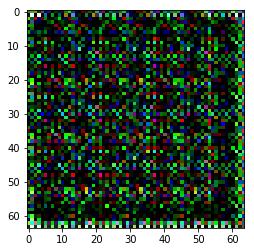

In [ ]:
plt.imshow(tst[0].cpu().numpy().transpose(1,2,0))

RuntimeError: number of dims don't match in permute

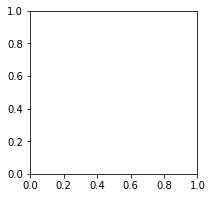

In [ ]:
img.show()